In [54]:
import xarray as xr
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import pandas as pd
import string
from src import config_cesm
from src.models.diagnostics import roll_metric
from src.utils import util_cesm
REFERENCE_GRID = util_cesm.generate_sps_grid()

def add_hatching(ax, significance_mask, x_edges, y_edges, hatch='///', edgecolor='k'):
    Ny, Nx = significance_mask.shape

    for i in range(Ny):
        for j in range(Nx):
            if significance_mask[i, j]:
                rect = mpatches.Rectangle(
                    (x_edges[j], y_edges[i]),
                    x_edges[j+1] - x_edges[j],
                    y_edges[i+1] - y_edges[i],
                    hatch=hatch,
                    fill=False,
                    edgecolor=edgecolor,
                    linewidth=0
                )
                ax.add_patch(rect)

def plot_markers(ax, exceeds_persistence, x_centers, y_centers, marker=".k"):
    for i in range(6):
        for j in range(12):
            if not exceeds_persistence[i,j]:
                ax.plot(x_centers[j], y_centers[i], marker, markersize=4) 

def subplot_labels(axs):
    panel_labels = list(string.ascii_lowercase)
    for i, ax in enumerate(axs.flatten()):
        ax.annotate(
            f"{panel_labels[i]})",
            xy=(0, 1), xycoords="axes fraction",
            xytext=(-0.1, 1.03), textcoords="axes fraction",
            ha="left", va="bottom",
            fontsize=11, fontweight="bold"
        )

## Plot the ACC difference between finetuned and non-finetuned baselines

In [11]:
# input_config = "input2" # input2 = sic only, input4 = sic+all
acc_agg_dict = {}
acc_agg_ft_dict = {}
significance_ds_acc = {}
persistence_acc = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_input2_ensemble/diagnostics/acc_agg_persist.nc"))["acc"]

rmse_agg_dict = {}
rmse_agg_ft_dict = {}
significance_ds_rmse = {}
persistence_rmse = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_input2_ensemble/diagnostics/rmse_agg_persist.nc"))["rmse"]
climatology_rmse = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_input2_ensemble/diagnostics/rmse_agg_climatology.nc"))["rmse"]


for input_config in ["input2", "input4"]:
    acc_agg = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_{input_config}_ensemble/diagnostics/acc_agg.nc"))["acc"]
    acc_agg_dict[input_config] = acc_agg.sel(nn_member_id=np.arange(20)).mean("nn_member_id")

    acc_agg_ft = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_{input_config}_finetune/diagnostics/acc_agg.nc"))["acc"]
    acc_agg_ft_dict[input_config] = acc_agg_ft.sel(nn_member_id=np.arange(20)).mean("nn_member_id")

    significance_ds_acc[input_config] = xr.open_dataset(
        os.path.join(config_cesm.ANALYSIS_RESULTS_DIRECTORY, f"confidence_intervals/obs_{input_config}_finetune_obs_{input_config}_ensemble_acc.nc")
    )

    rmse_agg = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_{input_config}_ensemble/diagnostics/rmse_agg.nc"))["rmse"]
    rmse_agg_dict[input_config] = rmse_agg.sel(nn_member_id=np.arange(20)).mean("nn_member_id")

    rmse_agg_ft = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_{input_config}_finetune/diagnostics/rmse_agg.nc"))["rmse"]
    rmse_agg_ft_dict[input_config] = rmse_agg_ft.sel(nn_member_id=np.arange(20)).mean("nn_member_id")

    significance_ds_rmse[input_config] = xr.open_dataset(
        os.path.join(config_cesm.ANALYSIS_RESULTS_DIRECTORY, f"confidence_intervals/obs_{input_config}_finetune_obs_{input_config}_ensemble_rmse.nc")
    )

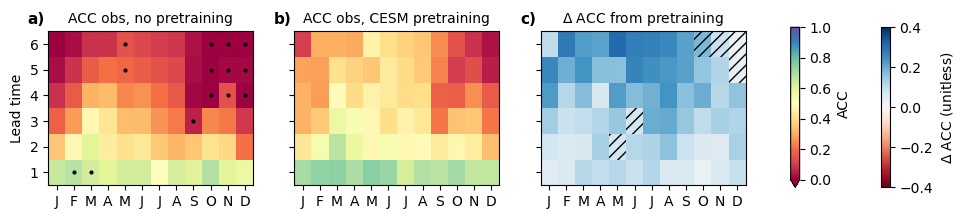

In [55]:
P_VALUE_CUTOFF = 0.05

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9,2), sharey=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

ax = axs[0]
cax2 = ax.pcolormesh(x, y, acc_agg_dict["input2"], cmap='Spectral', shading='flat', vmin=0, vmax=1)
beats_persistence = acc_agg_dict["input2"] > persistence_acc.squeeze()
plot_markers(ax, beats_persistence, x_centers, y_centers)
ax.set_yticks(y_centers, labels=np.arange(1,7,1))
ax.set_title(f"ACC obs, no pretraining", fontsize=10)
ax.set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
ax.set_ylabel("Lead time")

ax = axs[1]
ax.pcolormesh(x, y, acc_agg_ft_dict["input2"], cmap='Spectral', shading='flat', vmin=0, vmax=1)
beats_persistence = acc_agg_ft_dict["input2"] > persistence_acc.squeeze()
plot_markers(ax, beats_persistence, x_centers, y_centers)
ax.set_yticks(y_centers, labels=np.arange(1,7,1))
ax.set_title(f"ACC obs, CESM pretraining", fontsize=10)
ax.set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])

ax = axs[2]
cax = ax.pcolormesh(x, y, acc_agg_ft_dict["input2"] - acc_agg_dict["input2"], cmap='RdBu', shading='flat', vmin=-0.4, vmax=0.4)
significance_mask = (significance_ds_acc["input2"].p_value > P_VALUE_CUTOFF).astype(int)
add_hatching(ax, significance_mask, x, y)
ax.set_yticks(y_centers, labels=np.arange(1,7,1))
ax.set_title(rf"$\Delta$ ACC from pretraining", fontsize=10)
ax.set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])

cbar_ax = fig.add_axes([0.95, 0.1, 0.01, 0.8])
cbar_ax2 = fig.add_axes([1.05, 0.1, 0.01, 0.8])

plt.colorbar(cax, cax=cbar_ax2, label=r'$\Delta$ ACC (unitless)', orientation='vertical')
plt.colorbar(cax2, cax=cbar_ax, label=r'ACC', orientation='vertical', extend='min')

subplot_labels(axs)

plt.savefig("figures/cesm_new/exp3_finetune_acc.pdf", bbox_inches='tight')
plt.show()


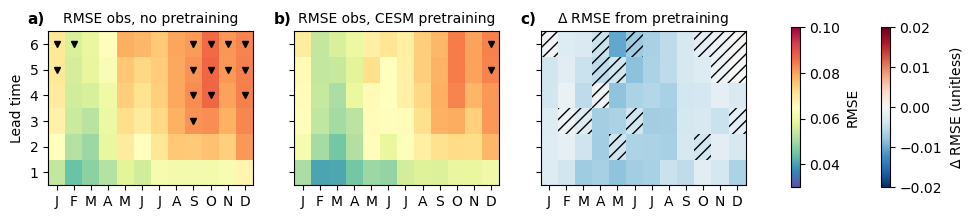

In [56]:
P_VALUE_CUTOFF = 0.05

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9,2), sharey=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

ax = axs[0]
cax = ax.pcolormesh(x, y, rmse_agg_dict["input2"], cmap='Spectral_r', shading='flat', vmin=0.03, vmax=0.1)
beats_climatology = rmse_agg_dict["input2"] < climatology_rmse.squeeze()
plot_markers(ax, beats_climatology, x_centers, y_centers, "vk")
ax.set_yticks(y_centers, labels=np.arange(1,7,1))
ax.set_title(f"RMSE obs, no pretraining", fontsize=10)
ax.set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
ax.set_ylabel("Lead time")

ax = axs[1]
ax.pcolormesh(x, y, rmse_agg_ft_dict["input2"], cmap='Spectral_r', shading='flat', vmin=0.03, vmax=0.1)
beats_climatology = rmse_agg_ft_dict["input2"] < climatology_rmse.squeeze()
plot_markers(ax, beats_climatology, x_centers, y_centers, "vk")
ax.set_yticks(y_centers, labels=np.arange(1,7,1))
ax.set_title(f"RMSE obs, CESM pretraining", fontsize=10)
ax.set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])

ax = axs[2]
cax2 = ax.pcolormesh(x, y, rmse_agg_ft_dict["input2"] - rmse_agg_dict["input2"], cmap='RdBu_r', shading='flat', vmin=-0.02, vmax=0.02)
significance_mask = (significance_ds_rmse["input2"].p_value > P_VALUE_CUTOFF).astype(int)
add_hatching(ax, significance_mask, x, y)
ax.set_yticks(y_centers, labels=np.arange(1,7,1))
ax.set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
ax.set_title(rf"$\Delta$ RMSE from pretraining", fontsize=10)

cbar_ax = fig.add_axes([0.95, 0.1, 0.01, 0.8])
cbar_ax2 = fig.add_axes([1.05, 0.1, 0.01, 0.8])

plt.colorbar(cax, cax=cbar_ax, label=r'RMSE', orientation='vertical')
plt.colorbar(cax2, cax=cbar_ax2, label=r'$\Delta$ RMSE (unitless)', orientation='vertical')

subplot_labels(axs)

plt.savefig("figures/cesm_new/exp3_finetune_rmse.pdf", bbox_inches='tight')
plt.show()


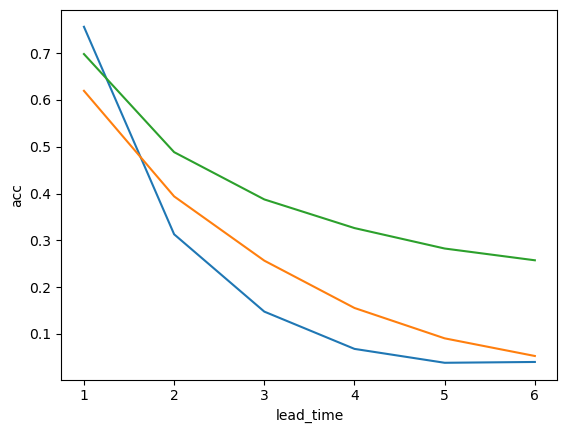

In [121]:
persistence_acc.mean("month").plot()
acc_agg_dict["input2"].mean("month").plot()
acc_agg_ft_dict["input2"].mean("month").plot()

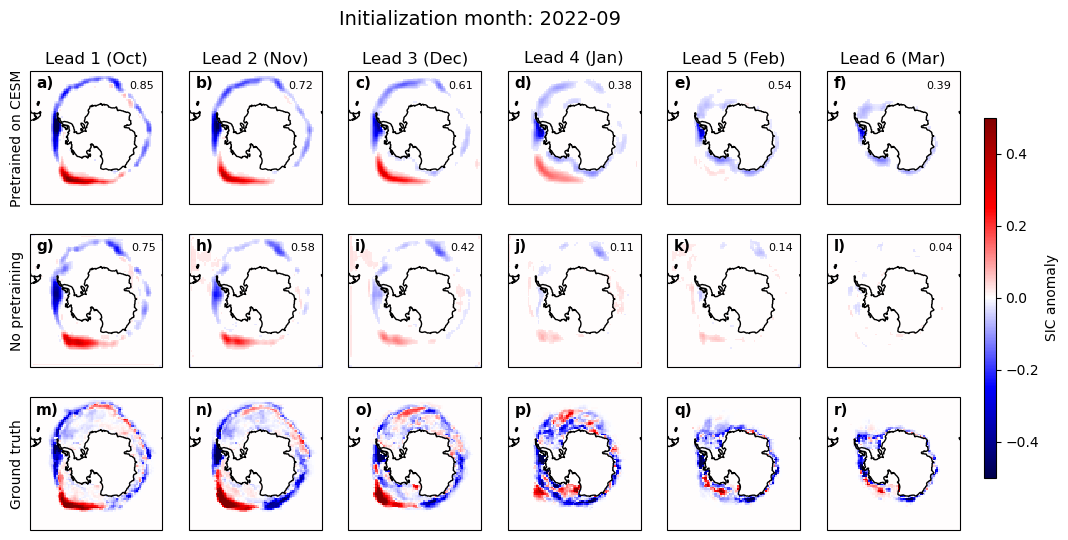

In [83]:
pred = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_ensemble/UNetRes3_best_predictions.nc")["predictions"]
pred_ft = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_finetune/UNetRes3_best_predictions.nc")["predictions"]
targets = xr.open_dataset("/scratch/users/yucli/cesm_data_processed/data_pairs/seaice_plus_auxiliary_obs/targets_member_obs.nc")["data"]
persist = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_ensemble/baselines/persistence_predictions.nc")["predictions"]

def calculate_masked_acc(pred, truth, dim):
    ice_occurrence_mask = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, "obs_data/ice_occurrence_mask.nc"))["mask"]
    pred = pred.where(ice_occurrence_mask == 1)
    truth = truth.where(ice_occurrence_mask == 1)
    return xr.corr(pred, truth, dim).values


def plot_pred_example(da_pred1, da_pred2, da_truth, start_prediction_month, savepath=None):
    import cartopy.crs as ccrs

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    lon = REFERENCE_GRID.lon.data
    lat = REFERENCE_GRID.lat.data

    fig, axs = plt.subplots(figsize=(12, 6), nrows=3, ncols=6, sharex=True, sharey=True, 
                            subplot_kw={'projection': ccrs.SouthPolarStereo()})
    init_month = start_prediction_month.astype('datetime64[M]')
    for i in range(6):
        pred1 = da_pred1.sel(start_prediction_month=start_prediction_month).isel(lead_time=i).squeeze()
        pred2 = da_pred2.sel(start_prediction_month=start_prediction_month).isel(lead_time=i).squeeze()
        truth = da_truth.sel(start_prediction_month=start_prediction_month).isel(lead_time=i).squeeze()

        im = axs[0,i].pcolormesh(lon, lat, pred1, transform=ccrs.PlateCarree(), vmin=-0.5, vmax=0.5, cmap="seismic")
        axs[1,i].pcolormesh(lon, lat, pred2, transform=ccrs.PlateCarree(), vmin=-0.5, vmax=0.5, cmap="seismic")
        axs[2,i].pcolormesh(lon, lat, truth, transform=ccrs.PlateCarree(), vmin=-0.5, vmax=0.5, cmap="seismic")

        # print acc 
        acc_1 = calculate_masked_acc(pred1, truth, ("x","y"))
        acc_2 = calculate_masked_acc(pred2, truth, ("x","y"))
        axs[0,i].annotate(np.round(acc_1, 2), xy=(0, 1), xycoords="axes fraction", xytext=(0.75, 0.85), textcoords="axes fraction",
            ha="left", va="bottom", fontsize=8)
        axs[1,i].text(35, -55, np.round(acc_2, 2), transform=ccrs.PlateCarree(), fontsize=8)

        axs[0,i].set_title(f"Lead {i+1} ({months[(pd.to_datetime(init_month).month + i) % 12]})")
        for j in range(3):
            axs[j,i].coastlines()
            axs[j,0].yaxis.set_visible(True) 
            axs[j,0].set_yticks([])
    axs[0,0].set_ylabel("Pretrained on CESM")
    axs[1,0].set_ylabel("No pretraining")
    axs[2,0].set_ylabel("Ground truth")

    plt.suptitle(f"Initialization month: {init_month}", fontsize=14)
    panel_labels = list(string.ascii_lowercase)
    for i, ax in enumerate(axs.flatten()):
        ax.annotate(
            f"{panel_labels[i]})",
            xy=(0, 1), xycoords="axes fraction", xytext=(0.05, 0.85), textcoords="axes fraction",
            ha="left", va="bottom", fontsize=11, fontweight="bold"
        )
    
    cbar_ax = fig.add_axes([0.92, 0.2, 0.01, 0.6])
    cbar = fig.colorbar(im, cax=cbar_ax, label='SIC anomaly')

plot_pred_example(pred_ft.sel(nn_member_id=0), pred.sel(nn_member_id=0), targets, np.datetime64("2022-09-01"))
# plt.savefig("figures/cesm_new/exp3_example_zw3.png", dpi=300, bbox_inches='tight')


In [37]:
pd.to_datetime("2022-09-01")

9

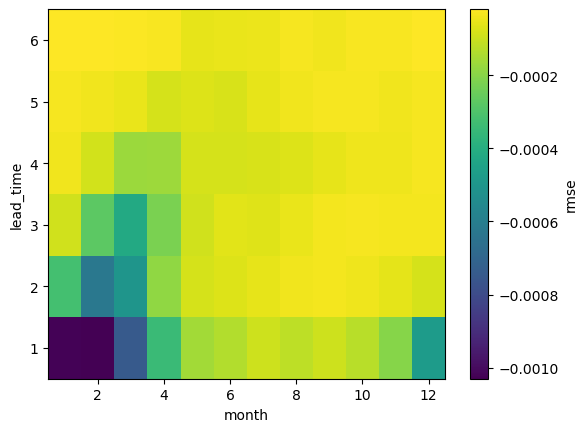

In [15]:
rmse_agg = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_ensemble/diagnostics/rmse_agg.nc")["rmse"]
rmse_agg_old = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_ensemble/diagnostics/rmse_agg_old.nc")["rmse"]

(rmse_agg - rmse_agg_old).sel(nn_member_id=np.arange(20)).mean("nn_member_id").plot()

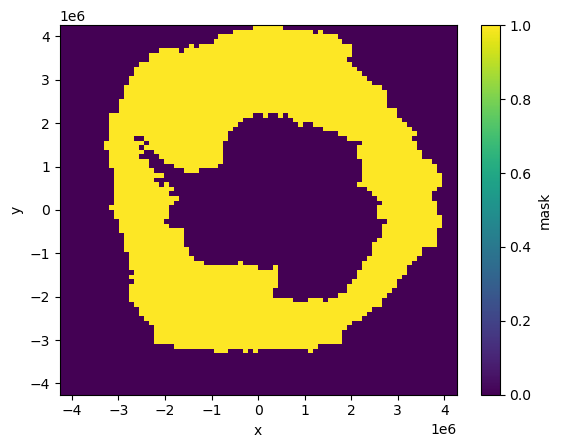

In [10]:
xr.open_dataset("/oak/stanford/groups/earlew/yuchen/obs_data/ice_occurrence_mask.nc")["mask"].plot()

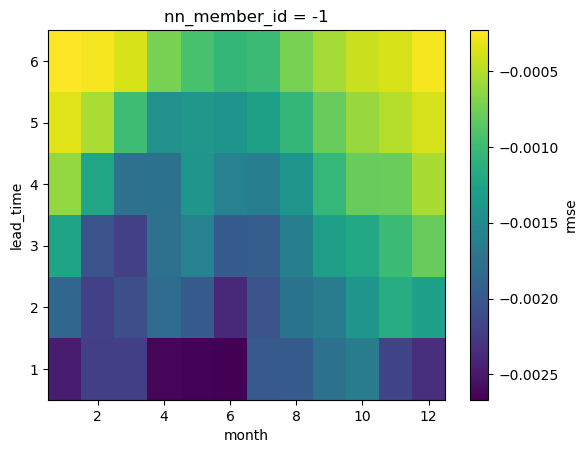

In [29]:
rmse_agg = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_ensemble/diagnostics/rmse_agg.nc")["rmse"]

(rmse_agg.sel(nn_member_id=-1) - rmse_agg.sel(nn_member_id=np.arange(20)).mean("nn_member_id")).plot()